# Advanced task: Dealing with unclean data

## Task statement

Typically, data to be analyzed in real world applications is not fully clean. Frequently, there are missing fields, invalid values, etc. 

A civil engineer is working in the design of a bridge, trying to find different alternatives, each of them having a total bridge weight and the degree of deformation in certain parts. After using an optimization software, she/he has obtained a .tsv file (attached to this task) with a number of rows indicating different trade-off designs. A plot of this file should look like like this graph:

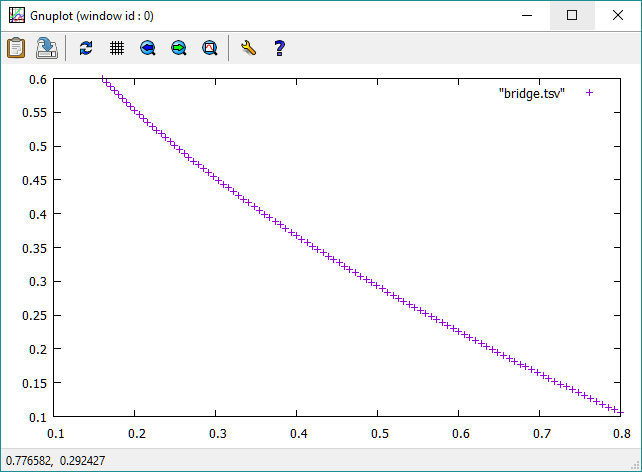

Unfortunately, some lines/fields have invalid values (blank lines, missing values, characters instead of numbers, etc), and there are also repeteated lines.

This task consists in developing a Jupyter notebook with PySpark to read the file, remove all the invalid lines and remove those that appear more than once, and plot the clean data.

The deliverable will be the Jupyter notebook.

## Task resolution

Importing required packages

In [2]:
import findspark
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

Initializing findspark to use pyspark in jupyter:

In [3]:
findspark.init()

Creating spark session:

In [4]:
spark_session = SparkSession \
    .builder \
    .getOrCreate()

Hide logs:

In [5]:
logger = spark_session._jvm.org.apache.log4j
logger.LogManager.getLogger("org").setLevel(logger.Level.WARN)

**Initial data exploration**

*Bridge.tsv* file contains 106 rows, one of them the header.

First sign that we detect is that file is a .tsv file but delimiter is a tabulation only in the header, as showed in the picture below:

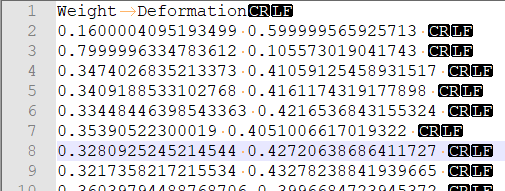

Consequently, before loading it to a Spark dataframe we need to replace all spaces by a tabulation using any editor, for example Notepad++.

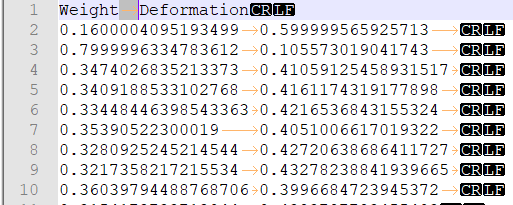

**Loading file**

Once this action is performed, file can be loaded to a Spark dataframe:

In [6]:
# Load tsv file
bridge_df = spark_session\
    .read\
    .format("csv")\
    .option("header", "true")\
    .option("delimiter", "\t") \
    .load("data/bridge.tsv")

bridge_df.printSchema()
bridge_df.show(106)
bridge_df.count()

root
 |-- Weight: string (nullable = true)
 |-- Deformation: string (nullable = true)

+-------------------+-------------------+
|             Weight|        Deformation|
+-------------------+-------------------+
| 0.1600004095193499|  0.599999565925713|
| 0.7999996334783612|  0.105573019041743|
| 0.3474026835213373|0.41059125458931517|
| 0.3409188533102768| 0.4161174319177898|
|0.33448446398543363| 0.4216536843155324|
|   0.35390522300019| 0.4051006617019322|
| 0.3280925245214544|0.42720638686411727|
| 0.3217358217215534|0.43278238841939665|
|0.36039794488768706| 0.3996684723945372|
| 0.3154172733712044| 0.4383797783455403|
| 0.3669234753668437| 0.3942579191642874|
|0.37345638999357544| 0.3888892255982278|
| 0.3091488764126171|0.44398842406579203|
| 0.3800121516706126|0.38354874656944227|
|0.30295098086750766|0.44959017652156535|
| 0.2967605824612727|               null|
|0.38657333470529276| 0.3782497818184258|
|0.29063517731969263| 0.4608941011769619|
|0.28454896813201636|0.46656868

104

**Data cleaning**

Above we can see that empty line is directly removed and not loaded to the dataframe.

As we can see in the schema of the dataframe, values are strings. Let's convert them to Double type in order to plot them later:

In [7]:
# Casting string values to double
clean_bridge_df_step1 = bridge_df \
    .withColumn('Weight', bridge_df['Weight'].cast('double')) \
    .withColumn('Deformation', bridge_df['Deformation'].cast('double'))

clean_bridge_df_step1.printSchema()
clean_bridge_df_step1.show(106)
clean_bridge_df_step1.count()

root
 |-- Weight: double (nullable = true)
 |-- Deformation: double (nullable = true)

+-------------------+-------------------+
|             Weight|        Deformation|
+-------------------+-------------------+
| 0.1600004095193499|  0.599999565925713|
| 0.7999996334783612|  0.105573019041743|
| 0.3474026835213373|0.41059125458931517|
| 0.3409188533102768| 0.4161174319177898|
|0.33448446398543363| 0.4216536843155324|
|   0.35390522300019| 0.4051006617019322|
| 0.3280925245214544|0.42720638686411727|
| 0.3217358217215534|0.43278238841939665|
|0.36039794488768706| 0.3996684723945372|
| 0.3154172733712044| 0.4383797783455403|
| 0.3669234753668437| 0.3942579191642874|
|0.37345638999357544| 0.3888892255982278|
| 0.3091488764126171|0.44398842406579203|
| 0.3800121516706126|0.38354874656944227|
|0.30295098086750766|0.44959017652156535|
| 0.2967605824612727|               null|
|0.38657333470529276| 0.3782497818184258|
|0.29063517731969263| 0.4608941011769619|
|0.28454896813201636|0.46656868

104

With above operation, we can see that values with including leters are converted to ``null``.

Removing duplicated values:

In [8]:
clean_bridge_df_step2 = clean_bridge_df_step1.dropDuplicates()

clean_bridge_df_step2.show(106)
clean_bridge_df_step2.count()

+-------------------+-------------------+
|             Weight|        Deformation|
+-------------------+-------------------+
|0.33448446398543363| 0.4216536843155324|
|  0.572968945115894|0.24305287848265267|
| 0.6348644998867188| 0.2032161525475955|
|0.18971116938088003| 0.5644415504920198|
| 0.7185978141827077|0.15229851636479771|
| 0.7043645514037609|0.16073571880342452|
| 0.6279429618162687|0.20757148355483204|
| 0.3091488764126171|0.44398842406579203|
|  0.525790747174963| 0.2748857010542112|
|0.40628079773284537| 0.3625984029187178|
|0.24925016280479606| 0.5007504192441555|
| 0.6486854221627268| 0.1945899156919917|
| 0.5661846565085659| 0.2475475719299154|
| 0.4326541976345938| 0.3422354548598913|
| 0.2105619652240353| 0.5411296943302976|
| 0.7848970329348788|0.11405585364696387|
| 0.3669234753668437| 0.3942579191642874|
|0.27851604294199267| 0.4722538129822601|
|  0.492385620193628| 0.2982980591482772|
| 0.5934590765189613|0.22963704914396238|
| 0.3409188533102768| 0.4161174319

100

Removing rows with ``null`` values:

In [13]:
clean_bridge_df_step3 = clean_bridge_df_step2.dropna()

clean_bridge_df_step3.show(106)
clean_bridge_df_step3.count()

+-------------------+-------------------+
|             Weight|        Deformation|
+-------------------+-------------------+
|0.33448446398543363| 0.4216536843155324|
|  0.572968945115894|0.24305287848265267|
| 0.6348644998867188| 0.2032161525475955|
|0.18971116938088003| 0.5644415504920198|
| 0.7185978141827077|0.15229851636479771|
| 0.7043645514037609|0.16073571880342452|
| 0.6279429618162687|0.20757148355483204|
| 0.3091488764126171|0.44398842406579203|
|  0.525790747174963| 0.2748857010542112|
|0.40628079773284537| 0.3625984029187178|
|0.24925016280479606| 0.5007504192441555|
| 0.6486854221627268| 0.1945899156919917|
| 0.5661846565085659| 0.2475475719299154|
| 0.4326541976345938| 0.3422354548598913|
| 0.2105619652240353| 0.5411296943302976|
| 0.7848970329348788|0.11405585364696387|
| 0.3669234753668437| 0.3942579191642874|
|0.27851604294199267| 0.4722538129822601|
|  0.492385620193628| 0.2982980591482772|
| 0.5934590765189613|0.22963704914396238|
| 0.3409188533102768| 0.4161174319

97

We can see above that data is now fully clean.

**Data visualization**

Now we are ready to plot the data by using ``matplotlib``:

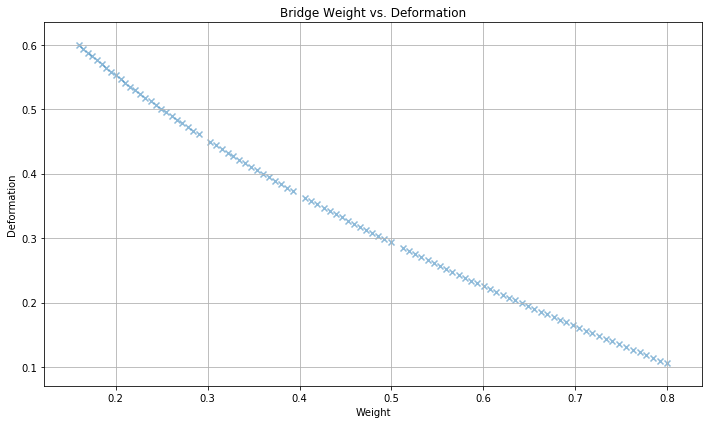

In [10]:
clean_bridge_pandas_df = clean_bridge_df_step3.toPandas()
x = clean_bridge_pandas_df['Weight']
y = clean_bridge_pandas_df['Deformation']

fig, ax = plt.subplots(figsize=(10,6))

ax.scatter(x, y,
            alpha=0.5,
            marker='x'
            )

ax.set_title('Bridge Weight vs. Deformation')    

ax.set_xlabel('Weight')
ax.set_ylabel('Deformation')
ax.grid()
plt.tight_layout()

plt.show() 